In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline

In [2]:
from tf_ann_model.processing.data_management import load_dataset

In [3]:
train = load_dataset(file_name='AWID-CLS-R-Trn.csv')
test = load_dataset(file_name='AWID-CLS-R-Tst.csv')

In [4]:
from tf_ann_model.processing.data_management import prepare_data

X_train, y_train = prepare_data(train, train_data=True)
X_test, y_test = prepare_data(test, train_data=False)

config.DOWNSAMPLE_DATA =  False
config.DOWNSAMPLE_DATA =  False


In [5]:
from tf_ann_model.pipeline import tf_ann_pipe
from sklearn.pipeline import Pipeline

data_pipe = Pipeline(tf_ann_pipe.steps[:-2])

config.DOWNSAMPLE_DATA =  False
config.DOWNSAMPLE_DATA =  False


In [6]:
train_prep = data_pipe.fit_transform(X_train)
test_prep = data_pipe.transform(X_test)

In [7]:
eda_pipe = Pipeline(tf_ann_pipe.steps[:-7])

In [8]:
train_eda = eda_pipe.fit_transform(X_train)
test_eda = eda_pipe.transform(X_test)

In [9]:
columns_to_drop = [col for col in train_eda.columns if col not in train_prep.columns]

In [10]:
train_eda['class'] = train['class']
test_eda['class'] = test['class']

train_eda['frame.time_epoch'] = train['frame.time_epoch']
test_eda['frame.time_epoch'] = test['frame.time_epoch']

In [11]:
from classification_model.processing.feat_eng_categ import one_hot_encoder
ohe = one_hot_encoder(features='class')
train_eda = ohe.fit_transform(train)
test_eda = ohe.transform(test)

In [12]:
def h(content):
    display(HTML(content))
    
def timehist(df, tcol, target, col, target_first, clipping=9999999999999999, concat_df = False, odf = None):
    if concat_df == True:
        df = pd.concat([df, odf])
        
    title = target + ' Hist ' + col
    if( target_first==True):
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 3))
        plt.title(title)
        plt.show()
    elif( target_first==False):
        df[df[target] == 0].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        df[df[target] == 1].set_index(tcol)[col].clip(0, clipping).plot(style='.', title= title, figsize=(15, 3))
        plt.title(title)
        plt.show()

In [13]:
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \

def desc(df_train, col, target, include_test=False, df_test=None):
    d0 = _desc(df_train[col], col, 'Train')
    d1 = _desc(df_train.loc[df_train[target] == 1, col], col, 'Train impersonation')
    d2 = _desc(df_train.loc[df_train[target] == 0, col], col, 'Train not impersonation')
    if( include_test):
        d3 = _desc(df_test[col], col, 'Test')
        d4 = _desc(df_test.loc[df_test[target] == 1, col], col, 'Test impersonation')
        d5 = _desc(df_test.loc[df_test[target] == 0, col], col, 'Test not impersonation')
    if( include_test):
        dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    else:
        dd = d0.merge(d1).merge(d2)
    display(dd)
    
    h('<b>Most popular values (NaN = -999):</b>')
    N = 10
    d0 = df_train[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
    d0 = d0.head(N)
    d0 = d0.rename({'size':'Count in train (desc)','mean':'Mean target train','sum':'Sum target train'}, axis=1)
    display(d0)
        
    d1 = df_test[[target,col]].groupby(col)[target].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
    d1 = d1.head(N)
    d1 = d1.rename({'size':'Count in test (desc)','mean':'Mean target test','sum':'Sum target test'}, axis=1)
    display(d1)

In [14]:
def hist1(df,col):
    plt.figure(figsize=(15, 3))
    plt.hist(df[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.show()

In [15]:
def corr1(df,col):
    N = None #10000
    num_vars = [f for f in df.columns if df[f].dtype != 'object']
    trx = df.head(N) if N is not None else df.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val)
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))

In [16]:
def numeric(df_input, tcol_input, target_input, col_input, target_first_input, df_test, include_test):
    timehist(df=df_input, tcol=tcol_input, target=target_input, col=col_input, target_first=target_first_input, odf=df_test, concat_df=include_test)
    hist1(df_input,col_input)
    desc(df_input, col_input, target_input, include_test, df_test)
    corr1(df_input,col_input)

In [17]:
def categorical(df, col, target, df_test, include_test):
    desc(df, col, target, include_test, df_test)

In [18]:
def proc(df, tcol, target, col, target_first, df_test, include_test):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(df, col, target, df_test, include_test) if train[col].dtype == 'object' else numeric(df, tcol, target, col, target_first, df_test, include_test)

In [19]:
columns = [col for col in train_eda if col in train_prep]

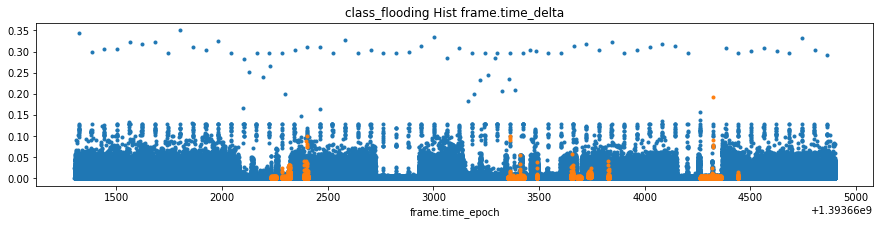

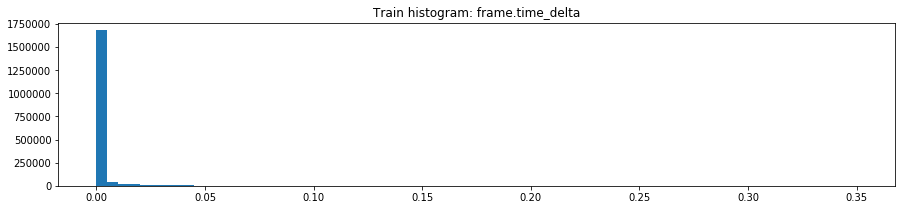

,frame.time_delta,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.000000,1.747090e+06
1,mean,2.004691e-03,0.001421,2.020877e-03
2,std,6.379538e-03,0.002312,6.455219e-03
3,min,1.000000e-06,0.000319,1.000000e-06
4,25%,3.150000e-04,0.000687,3.130000e-04
5,50%,5.490000e-04,0.000934,5.250000e-04
6,75%,1.113000e-03,0.001334,1.108000e-03
7,max,3.502630e-01,0.193682,3.502630e-01
8,unique values,4.360000e+04,4424.000000,4.356900e+04
9,NaNs,0.000000e+00,0.000000,0.000000e+00


,frame.time_delta,Count in train (desc),Mean target train,Sum target train
0,0.000005,30679,0.0,0
1,0.000004,23346,0.0,0
2,0.000006,15348,0.0,0
3,0.000315,13931,0.0,0
4,0.000312,12071,0.0,0
5,0.000308,10631,0.0,0
6,0.000316,8807,0.0,0
7,0.000311,7798,0.0,0
8,0.000019,7404,0.0,0
9,0.000314,7395,0.0,0


,frame.time_delta,Count in test (desc),Mean target test,Sum target test
0,0.000004,23118,0.0,0
1,0.000005,19749,0.0,0
2,0.000006,8295,0.0,0
3,0.000315,4887,0.0,0
4,0.000312,4246,0.0,0
5,0.000308,3469,0.0,0
6,0.000316,3111,0.0,0
7,0.000314,2892,0.0,0
8,0.000311,2670,0.0,0
9,0.000313,2618,0.0,0


,Column,Correlation with frame.time_delta
0,frame.time_delta_displayed,1.000000
1,frame.time_delta,1.000000
2,radiotap.channel.type.cck,0.157956
3,wlan_mgt.fixed.capabilities.privacy,0.127482
4,wlan.ba.control.ackpolicy,0.094451
5,wlan_mgt.fixed.auth.alg,0.053855
65,radiotap.present.channel,-0.214867
66,radiotap.present.flags,-0.214867
67,radiotap.present.tsft,-0.214867
68,radiotap.present.dbm_antsignal,-0.214867


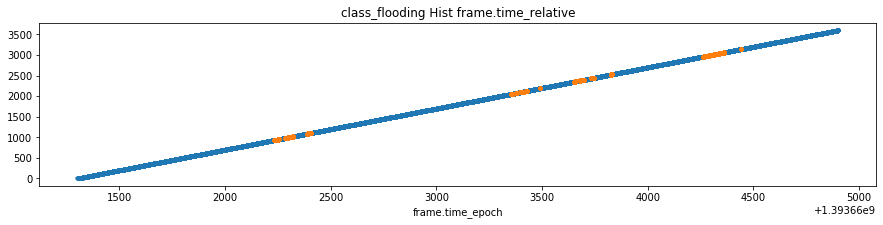

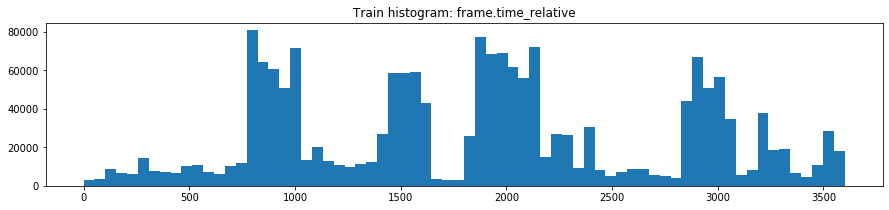

,frame.time_relative,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.000000,1.747090e+06
1,mean,1.870295e+03,2385.217154,1.856005e+03
2,std,8.674439e+02,817.502697,8.644260e+02
3,min,2.427100e-02,930.652482,2.427100e-02
4,25%,1.027876e+03,2075.291956,1.012647e+03
5,50%,1.902615e+03,2968.874539,1.895103e+03
6,75%,2.524325e+03,3013.594200,2.397503e+03
7,max,3.599571e+03,3139.027007,3.599571e+03
8,unique values,1.795574e+06,48484.000000,1.747090e+06
9,NaNs,0.000000e+00,0.000000,0.000000e+00


,frame.time_relative,Count in train (desc),Mean target train,Sum target train
0,0.024271,1,0,0
1,2142.285757,1,0,0
2,2142.292011,1,0,0
3,2142.291579,1,0,0
4,2142.291147,1,0,0
5,2142.291107,1,0,0
6,2142.291021,1,0,0
7,2142.287786,1,0,0
8,2142.287315,1,0,0
9,2142.286868,1,0,0


,frame.time_relative,Count in test (desc),Mean target test,Sum target test
0,0.001056,1,0,0
1,838.191974,1,0,0
2,838.186541,1,0,0
3,838.186545,1,0,0
4,838.186908,1,0,0
5,838.187511,1,0,0
6,838.187516,1,0,0
7,838.189340,1,0,0
8,838.192103,1,0,0
9,838.183844,1,0,0


,Column,Correlation with frame.time_relative
0,frame.time_relative,1.000000
1,frame.time_epoch,1.000000
2,radiotap.mactime,1.000000
3,wlan.wep.key,0.231201
4,radiotap.channel.type.cck,0.222206
5,wlan_mgt.fixed.category_code,0.206182
65,radiotap.channel.type.ofdm,-0.222206
66,wlan.fc.subtype,-0.224889
67,data.len,-0.307095
68,wlan_mgt.tcprep.trsmt_pow,-0.361786


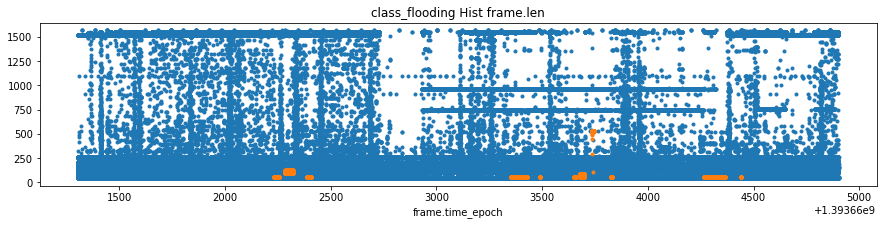

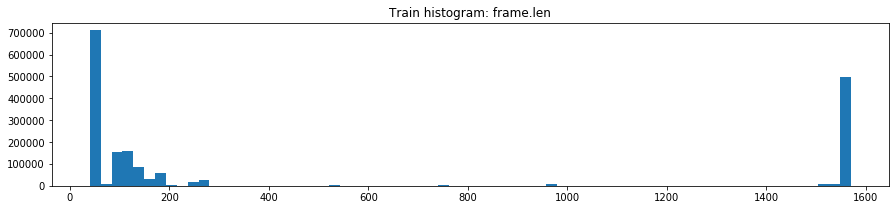

,frame.len,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.000000,1.747090e+06
1,mean,5.153151e+02,75.203696,5.275287e+02
2,std,6.649246e+02,83.638935,6.698325e+02
3,min,4.000000e+01,56.000000,4.000000e+01
4,25%,4.000000e+01,56.000000,4.000000e+01
5,50%,1.120000e+02,56.000000,1.240000e+02
6,75%,1.552000e+03,56.000000,1.552000e+03
7,max,1.570000e+03,530.000000,1.570000e+03
8,unique values,1.334000e+03,45.000000,1.332000e+03
9,NaNs,0.000000e+00,0.000000,0.000000e+00


,frame.len,Count in train (desc),Mean target train,Sum target train
0,40,452821,0.000000,0
1,1552,265889,0.000000,0
2,1554,230933,0.000000,0
3,56,222708,0.186913,41627
4,98,145035,0.000365,53
5,124,123930,0.000000,0
6,185,38668,0.000000,0
7,128,30501,0.000000,0
8,148,30409,0.000000,0
9,159,27623,0.000000,0


,frame.len,Count in test (desc),Mean target test,Sum target test
0,40,185920,0.009461,1759
1,1552,98328,0.000000,0
2,124,39058,0.000691,27
3,1560,30586,0.000000,0
4,98,30029,0.000000,0
5,1554,27915,0.000000,0
6,66,18606,0.000000,0
7,118,17920,0.000000,0
8,185,14972,0.000000,0
9,128,13217,0.006507,86


,Column,Correlation with frame.len
0,frame.len,1.000000
1,frame.cap_len,1.000000
2,data.len,0.999999
3,wlan.ba.control.ackpolicy,0.946789
4,wlan.qos.tid,0.911669
5,wlan.qos.priority,0.911669
65,wlan_mgt.fixed.capabilities.privacy,-0.554346
66,radiotap.channel.type.cck,-0.567742
67,wlan_mgt.tcprep.trsmt_pow,-0.961154
68,wlan_mgt.tcprep.link_mrg,-0.988610


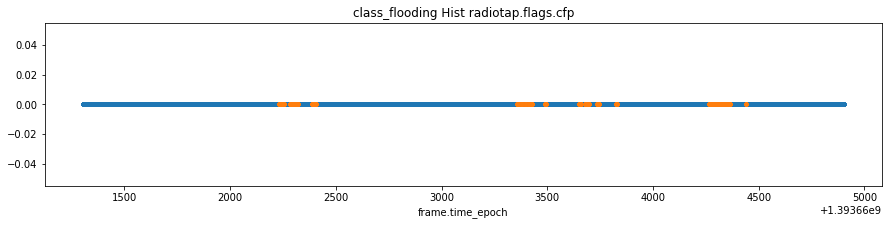

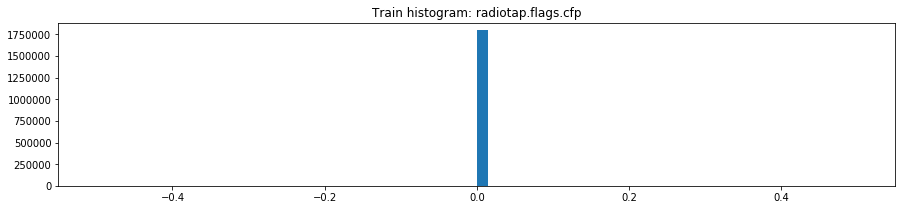

,radiotap.flags.cfp,Train,Train impersonation,Train not impersonation
0,count,1.794794e+06,48484.0,1.746310e+06
1,mean,0.000000e+00,0.0,0.000000e+00
2,std,0.000000e+00,0.0,0.000000e+00
3,min,0.000000e+00,0.0,0.000000e+00
4,25%,0.000000e+00,0.0,0.000000e+00
5,50%,0.000000e+00,0.0,0.000000e+00
6,75%,0.000000e+00,0.0,0.000000e+00
7,max,0.000000e+00,0.0,0.000000e+00
8,unique values,2.000000e+00,1.0,2.000000e+00
9,NaNs,7.800000e+02,0.0,7.800000e+02


,radiotap.flags.cfp,Count in train (desc),Mean target train,Sum target train
0,0.0,1794794,0.027014,48484


,radiotap.flags.cfp,Count in test (desc),Mean target test,Sum target test
0,0.0,575382,0.014072,8097


,Column,Correlation with radiotap.flags.cfp
0,frame.interface_id,NaN
1,frame.dlt,NaN
2,frame.offset_shift,NaN
3,frame.time_epoch,NaN
4,frame.time_delta,NaN
5,frame.time_delta_displayed,NaN


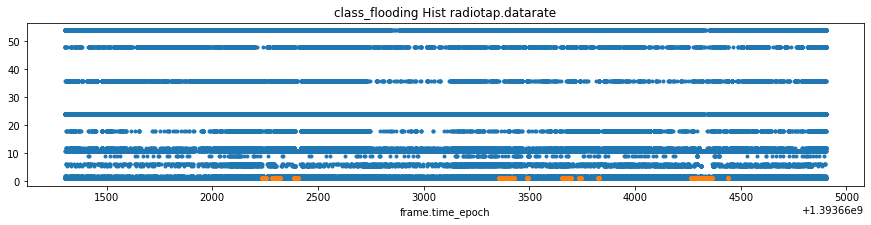

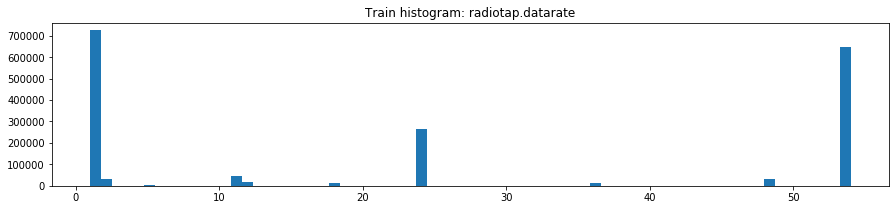

,radiotap.datarate,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.0,1.747090e+06
1,mean,2.513951e+01,1.0,2.580941e+01
2,std,2.373590e+01,0.0,2.371514e+01
3,min,1.000000e+00,1.0,1.000000e+00
4,25%,1.000000e+00,1.0,1.000000e+00
5,50%,2.400000e+01,1.0,2.400000e+01
6,75%,5.400000e+01,1.0,5.400000e+01
7,max,5.400000e+01,1.0,5.400000e+01
8,unique values,1.200000e+01,1.0,1.200000e+01
9,NaNs,0.000000e+00,0.0,0.000000e+00


,radiotap.datarate,Count in train (desc),Mean target train,Sum target train
0,1.0,724033,0.066964,48484
1,54.0,648415,0.000000,0
2,24.0,266381,0.000000,0
3,11.0,43882,0.000000,0
4,2.0,33956,0.000000,0
5,48.0,30251,0.000000,0
6,12.0,16182,0.000000,0
7,36.0,14859,0.000000,0
8,18.0,14245,0.000000,0
9,5.5,1730,0.000000,0


,radiotap.datarate,Count in test (desc),Mean target test,Sum target test
0,1.0,184682,0.043838,8096
1,54.0,167412,0.000000,0
2,24.0,133667,0.000000,0
3,36.0,18282,0.000000,0
4,11.0,17539,0.000000,0
5,48.0,17217,0.000000,0
6,12.0,16594,0.000000,0
7,18.0,15574,0.000000,0
8,2.0,3630,0.000000,0
9,5.5,473,0.000000,0


,Column,Correlation with radiotap.datarate
0,radiotap.datarate,1.000000
1,radiotap.channel.type.ofdm,0.892636
2,frame.len,0.755426
3,frame.cap_len,0.755426
4,wlan.fc.type,0.726434
5,wlan.fc.protected,0.706728
50,radiotap.mactime,-0.218059
51,wlan_mgt.fixed.sequence,-0.240437
52,wlan.duration,-0.271047
53,wlan.wep.key,-0.286565


,wlan.fc.type_subtype,Train,Train impersonation,Train not impersonation
0,count,1795574,48484,1747090
1,unique,21,6,21
2,top,0x28,0x0c,0x28
3,freq,661349,26002,661349
4,unique values,21,6,21
5,NaNs,0,0,0
6,NaNs share,0,0,0


,wlan.fc.type_subtype,Count in train (desc),Mean target train,Sum target train
0,0x28,661349,0.000000,0
1,0x1d,416915,0.000000,0
2,0x20,233909,0.000000,0
3,0x0c,206058,0.126188,26002
4,0x08,133015,0.013525,1799
5,0x1c,35906,0.000000,0
6,0x05,19077,0.081669,1558
7,0x24,18564,0.000000,0
8,0x0b,15999,0.022939,367
9,0x0a,15658,0.997892,15625


,wlan.fc.type_subtype,Count in test (desc),Mean target test,Sum target test
0,0x28,187804,0.000000,0
1,0x1d,183656,0.000000,0
2,0x20,126862,0.000000,0
3,0x08,52972,0.011308,599
4,0x05,6937,0.000000,0
5,0x0c,5963,0.785175,4682
6,0x24,5340,0.030899,165
7,0x04,2690,0.137175,369
8,0x1c,2264,0.776943,1759
9,0x0a,326,0.993865,324


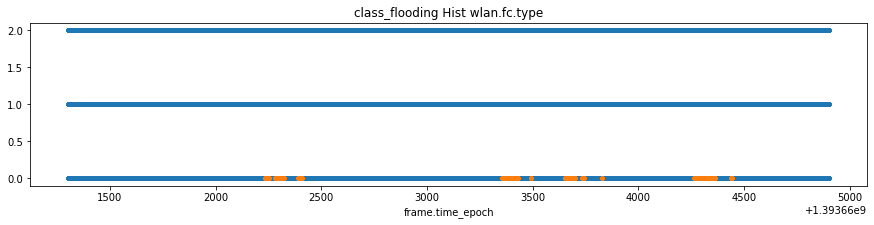

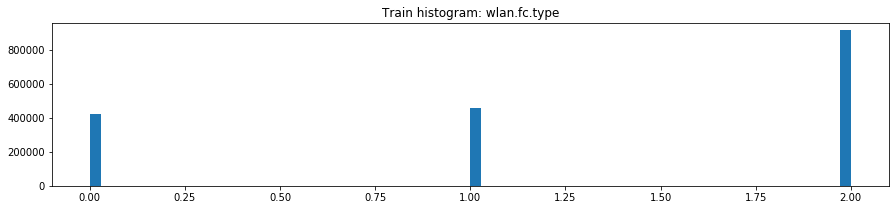

,wlan.fc.type,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.0,1.747090e+06
1,mean,1.272583e+00,0.0,1.307899e+00
2,std,8.198057e-01,0.0,8.028343e-01
3,min,0.000000e+00,0.0,0.000000e+00
4,25%,1.000000e+00,0.0,1.000000e+00
5,50%,2.000000e+00,0.0,2.000000e+00
6,75%,2.000000e+00,0.0,2.000000e+00
7,max,2.000000e+00,0.0,2.000000e+00
8,unique values,3.000000e+00,1.0,3.000000e+00
9,NaNs,0.000000e+00,0.0,0.000000e+00


,wlan.fc.type,Count in train (desc),Mean target train,Sum target train
0,2,914814,0.000000,0
1,1,455389,0.000000,0
2,0,425371,0.113981,48484


,wlan.fc.type,Count in test (desc),Mean target test,Sum target test
0,2,320097,0.000515,165
1,1,186198,0.010516,1958
2,0,69347,0.086146,5974


,Column,Correlation with wlan.fc.type
0,wlan.fc.type,1.000000
1,wlan.fc.protected,0.875106
2,radiotap.datarate,0.726434
3,radiotap.channel.type.ofdm,0.610470
4,frame.len,0.570831
5,frame.cap_len,0.570831
40,class_flooding,-0.258593
41,wlan.duration,-0.268009
42,wlan.fc.retry,-0.340556
43,wlan.fc.subtype,-0.454027


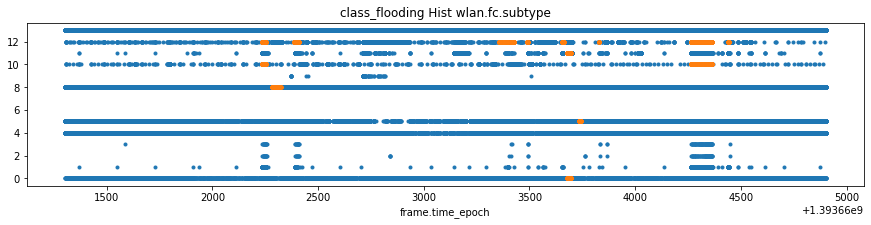

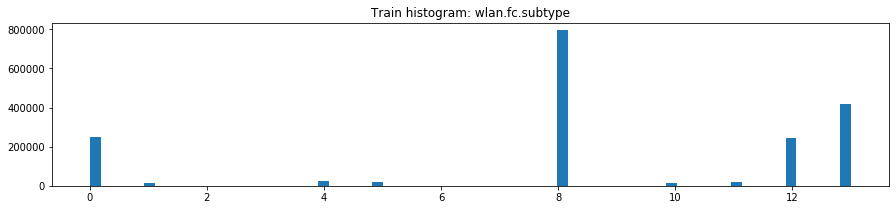

,wlan.fc.subtype,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.000000,1.747090e+06
1,mean,8.499055e+00,10.199097,8.451877e+00
2,std,4.173016e+00,3.086589,4.189334e+00
3,min,0.000000e+00,0.000000,0.000000e+00
4,25%,8.000000e+00,10.000000,8.000000e+00
5,50%,8.000000e+00,12.000000,8.000000e+00
6,75%,1.200000e+01,12.000000,1.200000e+01
7,max,1.300000e+01,12.000000,1.300000e+01
8,unique values,1.200000e+01,6.000000,1.200000e+01
9,NaNs,0.000000e+00,0.000000,0.000000e+00


,wlan.fc.subtype,Count in train (desc),Mean target train,Sum target train
0,8,794387,0.002265,1799
1,13,416943,0.000000,0
2,0,249393,0.012563,3133
3,12,242956,0.107023,26002
4,4,25443,0.000000,0
5,5,19077,0.081669,1558
6,11,17274,0.021246,367
7,10,16850,0.927300,15625
8,1,12973,0.000000,0
9,3,109,0.000000,0


,wlan.fc.subtype,Count in test (desc),Mean target test,Sum target test
0,8,240776,0.002488,599
1,13,183659,0.000000,0
2,0,126911,0.000000,0
3,12,8318,0.774345,6441
4,4,8030,0.066501,534
5,5,6937,0.000000,0
6,11,504,0.394841,199
7,10,393,0.824427,324
8,1,60,0.000000,0
9,3,31,0.000000,0


,Column,Correlation with wlan.fc.subtype
0,wlan.fc.subtype,1.000000
1,wlan.ba.control.ackpolicy,0.946789
2,data.len,0.570980
3,wlan_mgt.fixed.capabilities.privacy,0.458511
4,class_normal,0.398813
5,wlan.fc.retry,0.169900
63,class_injection,-0.395906
64,wlan.fc.type,-0.454027
65,wlan.fc.protected,-0.597087
66,wlan_mgt.tim.dtim_period,-0.846356


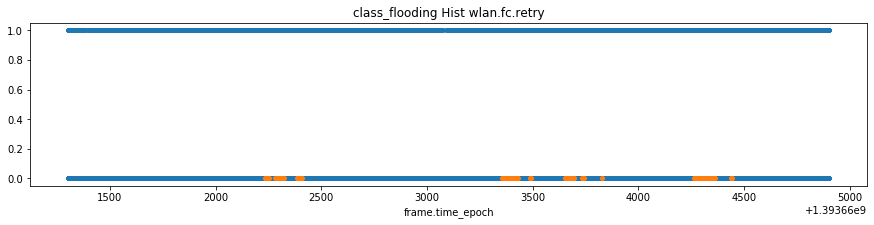

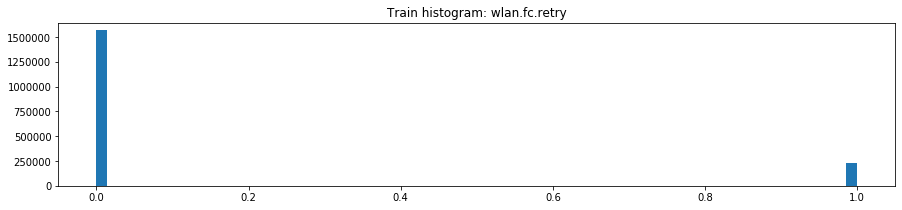

,wlan.fc.retry,Train,Train impersonation,Train not impersonation
0,count,1.795574e+06,48484.0,1.747090e+06
1,mean,1.271081e-01,0.0,1.306355e-01
2,std,3.330941e-01,0.0,3.370014e-01
3,min,0.000000e+00,0.0,0.000000e+00
4,25%,0.000000e+00,0.0,0.000000e+00
5,50%,0.000000e+00,0.0,0.000000e+00
6,75%,0.000000e+00,0.0,0.000000e+00
7,max,1.000000e+00,0.0,1.000000e+00
8,unique values,2.000000e+00,1.0,2.000000e+00
9,NaNs,0.000000e+00,0.0,0.000000e+00


,wlan.fc.retry,Count in train (desc),Mean target train,Sum target train
0,0,1567342,0.030934,48484
1,1,228232,0.000000,0


,wlan.fc.retry,Count in test (desc),Mean target test,Sum target test
0,0,537295,0.01507,8097
1,1,38347,0.00000,0


,Column,Correlation with wlan.fc.retry
0,wlan.fc.retry,1.000000
1,wlan.duration,0.347890
2,radiotap.channel.type.cck,0.228849
3,wlan.fc.subtype,0.169900
4,class_normal,0.120321
5,wlan_mgt.tcprep.link_mrg,0.114708
62,radiotap.datarate,-0.191576
63,radiotap.channel.type.ofdm,-0.228849
64,wlan.ba.control.ackpolicy,-0.247819
65,wlan.fc.type,-0.340556


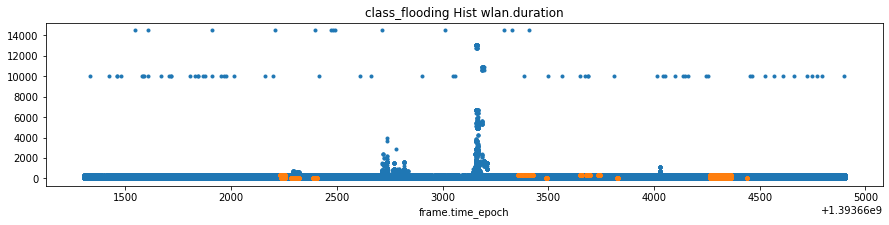

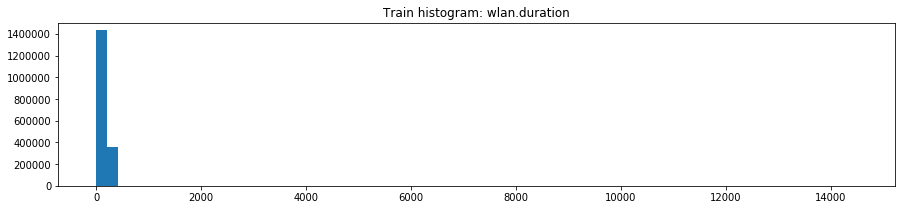

,wlan.duration,Train,Train impersonation,Train not impersonation
0,count,1.794382e+06,48484.000000,1.745898e+06
1,mean,8.402897e+01,171.656010,8.159554e+01
2,std,1.731928e+02,156.316043,1.730059e+02
3,min,0.000000e+00,0.000000,0.000000e+00
4,25%,0.000000e+00,0.000000,0.000000e+00
5,50%,4.400000e+01,314.000000,4.400000e+01
6,75%,4.400000e+01,314.000000,4.400000e+01
7,max,1.450000e+04,314.000000,1.450000e+04
8,unique values,3.230000e+02,2.000000,3.230000e+02
9,NaNs,1.192000e+03,0.000000,1.192000e+03


,wlan.duration,Count in train (desc),Mean target train,Sum target train
0,44.0,700767,0.000000,0
1,0.0,699624,0.031415,21979
2,314.0,292874,0.090500,26505
3,320.0,39469,0.000000,0
4,308.0,21919,0.000000,0
5,48.0,14292,0.000000,0
6,106.0,7382,0.000000,0
7,258.0,3847,0.000000,0
8,124.0,2093,0.000000,0
9,110.0,1879,0.000000,0


,wlan.duration,Count in test (desc),Mean target test,Sum target test
0,0.0,277211,0.023578,6536
1,44.0,224313,0.000000,0
2,314.0,53177,0.029336,1560
3,48.0,14741,0.000000,0
4,258.0,2077,0.000000,0
5,320.0,1374,0.000000,0
6,162.0,559,0.000000,0
7,52.0,524,0.000000,0
8,304.0,394,0.000000,0
9,213.0,206,0.000000,0


,Column,Correlation with wlan.duration
0,wlan.duration,1.000000
1,wlan_mgt.tim.dtim_count,0.845448
2,wlan_mgt.tim.dtim_period,0.829190
3,wlan.fc.retry,0.347890
4,radiotap.channel.type.cck,0.330454
5,wlan_mgt.fixed.sequence,0.309290
65,radiotap.datarate,-0.271047
66,radiotap.channel.type.ofdm,-0.330454
67,wlan_mgt.fixed.capabilities.privacy,-0.389574
68,wlan_mgt.fixed.category_code,-0.463580


,wlan.sa,Train,Train impersonation,Train not impersonation
0,count,1340185,48484,1291701
1,unique,3472,3386,99
2,top,00:13:33:87:62:6d,b0:48:7a:e2:62:23,00:13:33:87:62:6d
3,freq,573730,13979,573186
4,unique values,3473,3386,100
5,NaNs,455389,0,455389
6,NaNs share,0.2536,0,0.2607


,wlan.sa,Count in train (desc),Mean target train,Sum target train
0,00:13:33:87:62:6d,573730,0.000948,544
1,28:c6:8e:86:d3:d6,234723,0.038620,9065
2,00:18:41:95:de:dd,137596,0.000000,0
3,c0:18:85:94:b6:55,124391,0.007645,951
4,b0:48:7a:e2:62:23,62341,0.224234,13979
5,00:25:bc:ed:07:cf,41516,0.029699,1233
6,38:22:9d:ae:c5:65,28219,0.010135,286
7,20:64:32:54:c9:da,26372,0.015774,416
8,b0:48:7a:e2:64:af,23260,0.000000,0
9,3c:5a:37:8c:9a:41,22330,0.012718,284


,wlan.sa,Count in test (desc),Mean target test,Sum target test
0,00:13:33:87:62:6d,187870,0.000458,86
1,00:18:41:95:de:dd,42193,0.000000,0
2,c0:18:85:94:b6:55,33829,0.000591,20
3,20:64:32:54:c9:da,25685,0.001908,49
4,28:c6:8e:86:d3:d6,19816,0.207408,4110
5,b0:48:7a:e2:62:23,10450,0.002967,31
6,38:22:9d:ae:c5:65,10034,0.005481,55
7,3c:5a:37:8c:9a:41,7479,0.000802,6
8,38:22:9d:c4:8d:28,6988,0.000000,0
9,00:18:de:1a:c1:df,4941,0.043716,216


,wlan.bssid,Train,Train impersonation,Train not impersonation
0,count,1341377,48484,1292893
1,unique,3391,3361,34
2,top,28:c6:8e:86:d3:d6,b0:48:7a:e2:62:23,28:c6:8e:86:d3:d6
3,freq,1110899,27868,1095304
4,unique values,3392,3361,35
5,NaNs,454197,0,454197
6,NaNs share,0.253,0,0.26


,wlan.bssid,Count in train (desc),Mean target train,Sum target train
0,28:c6:8e:86:d3:d6,1110899,0.014038,15595
1,b0:48:7a:e2:62:23,103558,0.269105,27868
2,00:13:33:87:62:6d,63359,0.017188,1089
3,38:22:9d:ae:c5:65,30761,0.018693,575
4,38:22:9d:c4:8d:28,16484,0.000000,0
5,ff:ff:ff:ff:ff:ff,6684,0.000000,0
6,fc:0a:81:0f:dc:70,4563,0.000000,0
7,00:13:33:1d:5c:62,344,0.000000,0
8,8c:e0:81:91:7e:70,309,0.000000,0
9,dc:02:8e:7f:39:5e,298,0.000000,0


,wlan.bssid,Count in test (desc),Mean target test,Sum target test
0,28:c6:8e:86:d3:d6,269293,0.017464,4703
1,00:13:33:87:62:6d,79414,0.002178,173
2,b0:48:7a:e2:62:23,11903,0.004873,58
3,38:22:9d:ae:c5:65,10669,0.010029,107
4,38:22:9d:c4:8d:28,6988,0.000000,0
5,fc:0a:81:0f:dc:70,3833,0.000000,0
6,ff:ff:ff:ff:ff:ff,2612,0.141271,369
7,dc:02:8e:7f:39:5e,1536,0.000000,0
8,00:13:33:1d:5c:62,920,0.000000,0
9,00:1d:19:88:e4:a8,572,0.000000,0


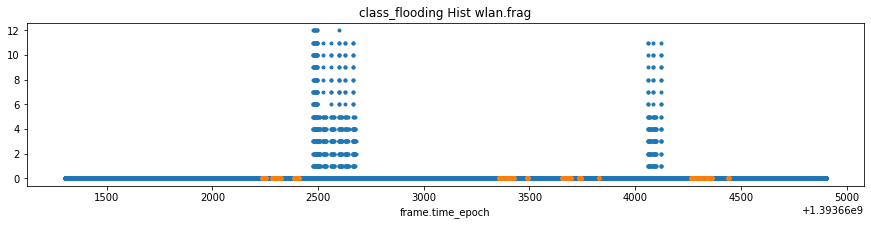

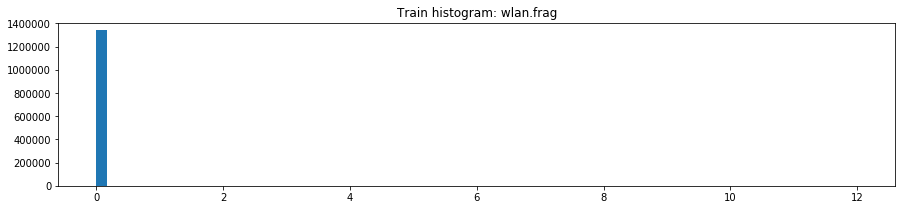

,wlan.frag,Train,Train impersonation,Train not impersonation
0,count,1.340185e+06,48484.0,1.291701e+06
1,mean,2.164627e-03,0.0,2.245876e-03
2,std,1.176390e-01,0.0,1.198257e-01
3,min,0.000000e+00,0.0,0.000000e+00
4,25%,0.000000e+00,0.0,0.000000e+00
5,50%,0.000000e+00,0.0,0.000000e+00
6,75%,0.000000e+00,0.0,0.000000e+00
7,max,1.200000e+01,0.0,1.200000e+01
8,unique values,1.400000e+01,1.0,1.400000e+01
9,NaNs,4.553890e+05,0.0,4.553890e+05


,wlan.frag,Count in train (desc),Mean target train,Sum target train
0,0.0,1339522,0.036195,48484
1,3.0,113,0.000000,0
2,2.0,106,0.000000,0
3,1.0,104,0.000000,0
4,4.0,102,0.000000,0
5,5.0,62,0.000000,0
6,10.0,31,0.000000,0
7,8.0,30,0.000000,0
8,7.0,29,0.000000,0
9,9.0,27,0.000000,0


,wlan.frag,Count in test (desc),Mean target test,Sum target test
0,0.0,369961,0.015596,5770
1,1.0,6613,0.000000,0
2,3.0,6229,0.000000,0
3,2.0,6206,0.000000,0
4,10.0,374,0.986631,369
5,4.0,24,0.000000,0
6,5.0,14,0.000000,0
7,6.0,5,0.000000,0
8,7.0,5,0.000000,0
9,9.0,5,0.000000,0


,Column,Correlation with wlan.frag
0,wlan.frag,1.000000
1,wlan.fc.frag,0.650193
2,class_injection,0.081252
3,wlan.wep.key,0.032724
4,wlan.duration,0.031416
5,radiotap.channel.type.cck,0.019768
30,radiotap.channel.type.ofdm,-0.019768
31,radiotap.datarate,-0.019852
32,data.len,-0.026066
33,wlan.fc.subtype,-0.033891


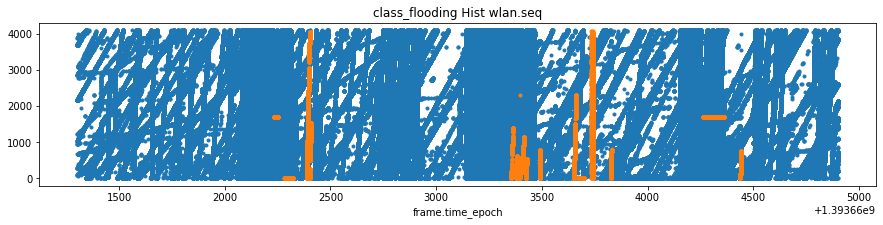

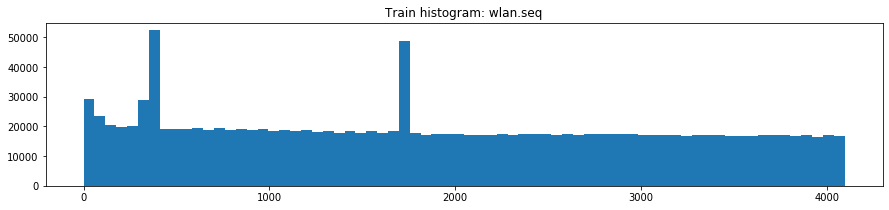

,wlan.seq,Train,Train impersonation,Train not impersonation
0,count,1.340185e+06,48484.000000,1.291701e+06
1,mean,1.910166e+03,1389.325571,1.929716e+03
2,std,1.200124e+03,746.840581,1.209487e+03
3,min,0.000000e+00,0.000000,0.000000e+00
4,25%,8.400000e+02,994.000000,8.380000e+02
5,50%,1.811000e+03,1703.000000,1.883000e+03
6,75%,2.940000e+03,1703.000000,2.977000e+03
7,max,4.095000e+03,4064.000000,4.095000e+03
8,unique values,4.097000e+03,3545.000000,4.097000e+03
9,NaNs,4.553890e+05,0.000000,4.553890e+05


,wlan.seq,Count in train (desc),Mean target train,Sum target train
0,1703.0,31511,0.989559,31182
1,345.0,9404,0.000851,8
2,355.0,8988,0.001001,9
3,359.0,8818,0.000907,8
4,364.0,8451,0.001065,9
5,368.0,7927,0.001514,12
6,0.0,6212,0.854475,5308
7,76.0,3146,0.002225,7
8,1.0,560,0.010714,6
9,2.0,488,0.008197,4


,wlan.seq,Count in test (desc),Mean target test,Sum target test
0,1293.0,25583,0.000039,1
1,0.0,1260,0.477778,602
2,1703.0,562,0.848754,477
3,10.0,526,0.709125,373
4,1.0,177,0.022599,4
5,12.0,176,0.028409,5
6,4.0,175,0.028571,5
7,3.0,174,0.028736,5
8,2.0,173,0.023121,4
9,9.0,165,0.018182,3


,Column,Correlation with wlan.seq
0,wlan.seq,1.000000
1,wlan_mgt.fixed.category_code,0.484672
2,wlan_mgt.tcprep.trsmt_pow,0.397393
3,wlan_mgt.tcprep.link_mrg,0.270832
4,class_normal,0.178442
5,data.len,0.099621
63,radiotap.mactime,-0.042464
64,radiotap.channel.type.cck,-0.068242
65,class_flooding,-0.084081
66,wlan.fc.pwrmgt,-0.190885


,wlan.bar.type,Train,Train impersonation,Train not impersonation
0,count,23,0,23
1,unique,1,0,1
2,top,0x02,NaN,0x02
3,freq,23,NaN,23
4,unique values,2,1,2
5,NaNs,1795551,48484,1747067
6,NaNs share,1,1,1


,wlan.bar.type,Count in train (desc),Mean target train,Sum target train
0,0x02,23,0,0


,wlan.bar.type,Count in test (desc),Mean target test,Sum target test


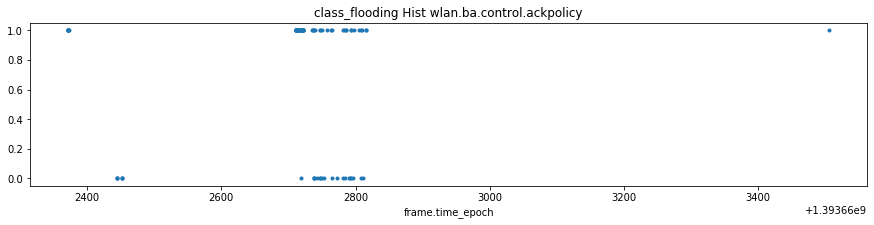

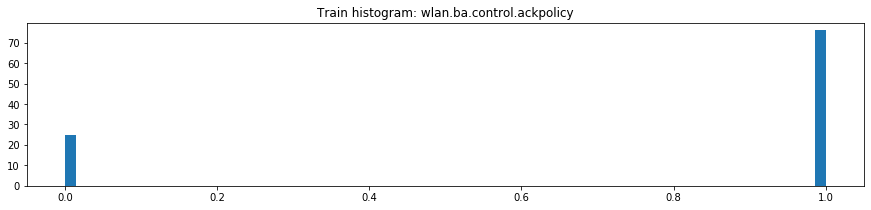

,wlan.ba.control.ackpolicy,Train,Train impersonation,Train not impersonation
0,count,1.010000e+02,0.0,1.010000e+02
1,mean,7.524752e-01,NaN,7.524752e-01
2,std,4.337267e-01,NaN,4.337267e-01
3,min,0.000000e+00,NaN,0.000000e+00
4,25%,1.000000e+00,NaN,1.000000e+00
5,50%,1.000000e+00,NaN,1.000000e+00
6,75%,1.000000e+00,NaN,1.000000e+00
7,max,1.000000e+00,NaN,1.000000e+00
8,unique values,3.000000e+00,1.0,3.000000e+00
9,NaNs,1.795473e+06,48484.0,1.746989e+06


,wlan.ba.control.ackpolicy,Count in train (desc),Mean target train,Sum target train
0,1.0,76,0,0
1,0.0,25,0,0


,wlan.ba.control.ackpolicy,Count in test (desc),Mean target test,Sum target test


,Column,Correlation with wlan.ba.control.ackpolicy
0,wlan.ba.control.ackpolicy,1.000000
1,frame.len,0.946789
2,frame.cap_len,0.946789
3,wlan.fc.subtype,0.946789
4,radiotap.dbm_antsignal,0.683097
5,radiotap.channel.type.ofdm,0.503909
13,wlan_mgt.fixed.sequence,0.015749
14,wlan.fc.pwrmgt,-0.174356
15,wlan.fc.retry,-0.247819
16,radiotap.channel.type.cck,-0.503909


,wlan.ba.bm,Train,Train impersonation,Train not impersonation
0,count,78,0,78
1,unique,32,0,32
2,top,00:00:00:00:00:00:00:00,NaN,00:00:00:00:00:00:00:00
3,freq,33,NaN,33
4,unique values,33,1,33
5,NaNs,1795496,48484,1747012
6,NaNs share,1,1,1


,wlan.ba.bm,Count in train (desc),Mean target train,Sum target train
0,00:00:00:00:00:00:00:00,33,0,0
1,ff:ff:1f:00:00:00:00:00,3,0,0
2,ff:ff:0f:00:00:00:00:00,3,0,0
3,ff:00:00:00:00:00:00:00,2,0,0
4,ff:ff:07:00:00:00:00:00,2,0,0
5,ff:ff:00:00:00:00:00:00,2,0,0
6,ff:7f:00:00:00:00:00:00,2,0,0
7,ff:3f:00:00:00:00:00:00,2,0,0
8,ff:ff:ff:ff:ff:ff:ff:ff,2,0,0
9,7f:00:00:00:00:00:00:00,2,0,0


,wlan.ba.bm,Count in test (desc),Mean target test,Sum target test


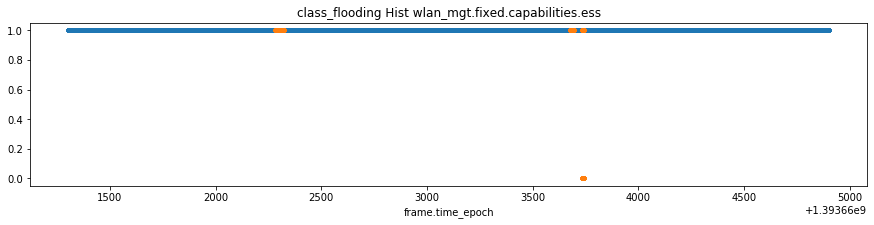

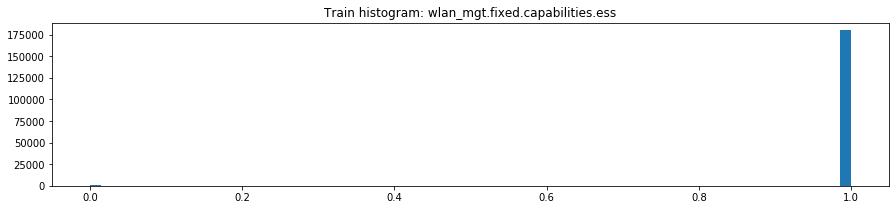

,wlan_mgt.fixed.capabilities.ess,Train,Train impersonation,Train not impersonation
0,count,1.807490e+05,6490.000000,1.742590e+05
1,mean,9.955795e-01,0.876888,1.000000e+00
2,std,6.633987e-02,0.328592,0.000000e+00
3,min,0.000000e+00,0.000000,1.000000e+00
4,25%,1.000000e+00,1.000000,1.000000e+00
5,50%,1.000000e+00,1.000000,1.000000e+00
6,75%,1.000000e+00,1.000000,1.000000e+00
7,max,1.000000e+00,1.000000,1.000000e+00
8,unique values,3.000000e+00,3.000000,2.000000e+00
9,NaNs,1.614825e+06,41994.000000,1.572831e+06


,wlan_mgt.fixed.capabilities.ess,Count in train (desc),Mean target train,Sum target train
0,1.0,179950,0.031625,5691
1,0.0,799,1.000000,799


,wlan_mgt.fixed.capabilities.ess,Count in test (desc),Mean target test,Sum target test
0,1.0,60072,0.009971,599


,Column,Correlation with wlan_mgt.fixed.capabilities.ess
0,wlan_mgt.tcprep.link_mrg,1.000000
1,wlan_mgt.fixed.capabilities.ess,1.000000
2,wlan_mgt.tcprep.trsmt_pow,0.990901
3,class_normal,0.271893
4,wlan_mgt.fixed.capabilities.short_slot_time,0.166031
5,wlan.fc.subtype,0.035767
44,wlan_mgt.tim.dtim_count,-0.688851
45,wlan_mgt.tim.dtim_period,-0.693745
46,wlan_mgt.rsn.version,-0.765080
47,wlan_mgt.rsn.akms.count,-0.790556


,wlan_mgt.fixed.listen_ival,Train,Train impersonation,Train not impersonation
0,count,15575,3133,12442
1,unique,5,1,5
2,top,0x0064,0x000a,0x0064
3,freq,11992,3133,11992
4,unique values,6,2,6
5,NaNs,1779999,45351,1734648
6,NaNs share,0.9913,0.9354,0.9929


,wlan_mgt.fixed.listen_ival,Count in train (desc),Mean target train,Sum target train
0,0x0064,11992,0.000000,0
1,0x000a,3495,0.896423,3133
2,0x0005,56,0.000000,0
3,0x0001,26,0.000000,0
4,0x0003,6,0.000000,0


,wlan_mgt.fixed.listen_ival,Count in test (desc),Mean target test,Sum target test
0,0x000a,41,0,0
1,0x0005,14,0,0
2,0x0001,9,0,0
3,0x0064,6,0,0
4,0x0003,2,0,0


,wlan_mgt.fixed.current_ap,Train,Train impersonation,Train not impersonation
0,count,91,0,91
1,unique,4,0,4
2,top,28:c6:8e:86:d3:d6,NaN,28:c6:8e:86:d3:d6
3,freq,47,NaN,47
4,unique values,5,1,5
5,NaNs,1795483,48484,1746999
6,NaNs share,0.9999,1,0.9999


,wlan_mgt.fixed.current_ap,Count in train (desc),Mean target train,Sum target train
0,28:c6:8e:86:d3:d6,47,0,0
1,38:22:9d:ae:c5:65,35,0,0
2,b0:48:7a:e2:62:23,7,0,0
3,00:13:33:87:62:6d,2,0,0


,wlan_mgt.fixed.current_ap,Count in test (desc),Mean target test,Sum target test
0,28:c6:8e:86:d3:d6,17,0,0
1,38:22:9d:ae:c5:65,6,0,0


,wlan_mgt.fixed.status_code,Train,Train impersonation,Train not impersonation
0,count,28951,367,28584
1,unique,3,1,3
2,top,0x0000,0x0000,0x0000
3,freq,26543,367,26176
4,unique values,4,2,4
5,NaNs,1766623,48117,1718506
6,NaNs share,0.9839,0.9924,0.9836


,wlan_mgt.fixed.status_code,Count in train (desc),Mean target train,Sum target train
0,0x0000,26543,0.013827,367
1,0x000d,2403,0.000000,0
2,0x000f,5,0.000000,0


,wlan_mgt.fixed.status_code,Count in test (desc),Mean target test,Sum target test
0,0x0000,332,0,0
1,0x000d,13,0,0
2,0x000f,1,0,0


,wlan_mgt.fixed.timestamp,Train,Train impersonation,Train not impersonation
0,count,152092,3357,148735
1,unique,137910,1,137910
2,top,0x0000000000000000,0x0000000000000000,0x0000000000000000
3,freq,7096,3357,3739
4,unique values,137911,2,137911
5,NaNs,1643482,45127,1598355
6,NaNs share,0.9153,0.9308,0.9149


,wlan_mgt.fixed.timestamp,Count in train (desc),Mean target train,Sum target train
0,0x0000000000000000,7096,0.473083,3357
1,0x000000000012cd80,5,0.000000,0
2,0x00000000000e1d80,5,0.000000,0
3,0x000000000007ed80,5,0.000000,0
4,0x0000000007161d80,4,0.000000,0
5,0x0000000007116d80,4,0.000000,0
6,0x000000002e6f8d80,4,0.000000,0
7,0x0000000028faad80,4,0.000000,0
8,0x00000000287c1d80,4,0.000000,0
9,0x0000000006fead80,4,0.000000,0


,wlan_mgt.fixed.timestamp,Count in test (desc),Mean target test,Sum target test
0,0x0000000000000000,2068,0.289652,599
1,0x000000000015fd80,3,0.000000,0
2,0x000000000007ed80,3,0.000000,0
3,0x0000000000177d80,3,0.000000,0
4,0x000000000018fd80,3,0.000000,0
5,0x00000000000e1d80,3,0.000000,0
6,0x0000000034d37d80,2,0.000000,0
7,0x0000000031cf8d80,2,0.000000,0
8,0x000000002b52ad80,2,0.000000,0
9,0x000000400e0c0184,2,0.000000,0


,wlan_mgt.fixed.aid,Train,Train impersonation,Train not impersonation
0,count,13082,0,13082
1,unique,6,0,6
2,top,0x0001,NaN,0x0001
3,freq,12981,NaN,12981
4,unique values,7,1,7
5,NaNs,1782492,48484,1734008
6,NaNs share,0.9927,1,0.9925


,wlan_mgt.fixed.aid,Count in train (desc),Mean target train,Sum target train
0,0x0001,12981,0,0
1,0x0003,36,0,0
2,0x0004,24,0,0
3,0x0005,24,0,0
4,0x0002,12,0,0
5,0x0006,5,0,0


,wlan_mgt.fixed.aid,Count in test (desc),Mean target test,Sum target test
0,0x0001,59,0,0
1,0x0002,13,0,0
2,0x0004,7,0,0
3,0x0005,6,0,0
4,0x0003,5,0,0
5,0x0006,1,0,0


,wlan_mgt.fixed.reason_code,Train,Train impersonation,Train not impersonation
0,count,221735,41646,180089
1,unique,25,21,6
2,top,0x0007,0x0001,0x0007
3,freq,172849,31180,162402
4,unique values,26,22,7
5,NaNs,1573839,6838,1567001
6,NaNs share,0.8765,0.141,0.8969


,wlan_mgt.fixed.reason_code,Count in train (desc),Mean target train,Sum target train
0,0x0007,172849,0.060440,10447
1,0x0001,31235,0.998239,31180
2,0x0006,17547,0.000000,0
3,0x0003,60,0.000000,0
4,0x0002,18,0.000000,0
5,0x0008,7,0.000000,0
6,0x64d7,1,1.000000,1
7,0xc87e,1,1.000000,1
8,0xbf17,1,1.000000,1
9,0xa5d9,1,1.000000,1


,wlan_mgt.fixed.reason_code,Count in test (desc),Mean target test,Sum target test
0,0x0007,5668,0.784227,4445
1,0x0001,481,0.991684,477
2,0x0008,84,1.000000,84
3,0x0006,39,0.000000,0
4,0x0003,14,0.000000,0
5,0x0002,3,0.000000,0


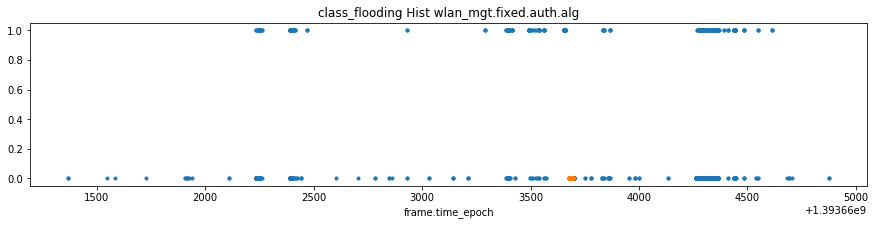

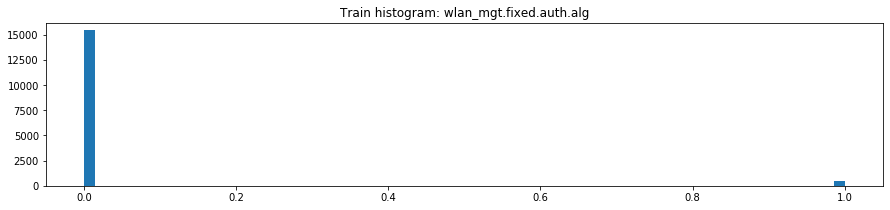

,wlan_mgt.fixed.auth.alg,Train,Train impersonation,Train not impersonation
0,count,1.586100e+04,367.0000,1.549400e+04
1,mean,2.818233e-02,0.0000,2.884988e-02
2,std,1.654987e-01,0.0000,1.673899e-01
3,min,0.000000e+00,0.0000,0.000000e+00
4,25%,0.000000e+00,0.0000,0.000000e+00
5,50%,0.000000e+00,0.0000,0.000000e+00
6,75%,0.000000e+00,0.0000,0.000000e+00
7,max,1.000000e+00,0.0000,1.000000e+00
8,unique values,3.000000e+00,2.0000,3.000000e+00
9,NaNs,1.779713e+06,48117.0000,1.731596e+06


,wlan_mgt.fixed.auth.alg,Count in train (desc),Mean target train,Sum target train
0,0.0,15414,0.02381,367
1,1.0,447,0.00000,0


,wlan_mgt.fixed.auth.alg,Count in test (desc),Mean target test,Sum target test
0,1.0,136,0,0
1,0.0,119,0,0


,Column,Correlation with wlan_mgt.fixed.auth.alg
0,wlan_mgt.fixed.auth.alg,1.000000
1,frame.len,0.628847
2,frame.cap_len,0.628847
3,radiotap.dbm_antsignal,0.270124
4,class_impersonation,0.204119
5,radiotap.datarate,0.114234
12,wlan.fc.retry,-0.048956
13,wlan.duration,-0.053735
14,frame.time_relative,-0.114786
15,frame.time_epoch,-0.114786


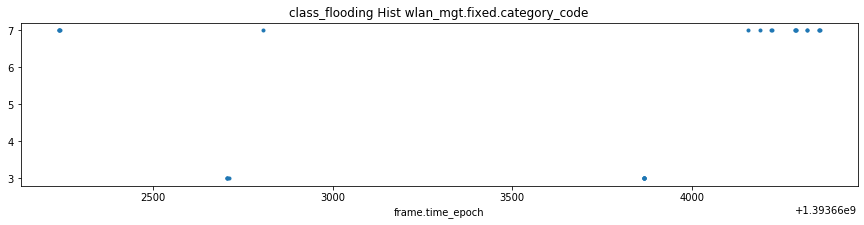

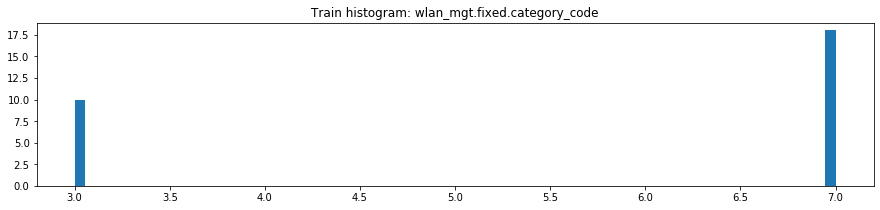

,wlan_mgt.fixed.category_code,Train,Train impersonation,Train not impersonation
0,count,2.800000e+01,0.0,2.800000e+01
1,mean,5.571429e+00,NaN,5.571429e+00
2,std,1.951800e+00,NaN,1.951800e+00
3,min,3.000000e+00,NaN,3.000000e+00
4,25%,3.000000e+00,NaN,3.000000e+00
5,50%,7.000000e+00,NaN,7.000000e+00
6,75%,7.000000e+00,NaN,7.000000e+00
7,max,7.000000e+00,NaN,7.000000e+00
8,unique values,3.000000e+00,1.0,3.000000e+00
9,NaNs,1.795546e+06,48484.0,1.747062e+06


,wlan_mgt.fixed.category_code,Count in train (desc),Mean target train,Sum target train
0,7.0,18,0,0
1,3.0,10,0,0


,wlan_mgt.fixed.category_code,Count in test (desc),Mean target test,Sum target test
0,7.0,3,0,0


,Column,Correlation with wlan_mgt.fixed.category_code
0,wlan_mgt.fixed.category_code,1.000000
1,radiotap.dbm_antsignal,0.638676
2,wlan.seq,0.484672
3,radiotap.mactime,0.206182
4,frame.time_epoch,0.206182
5,frame.time_relative,0.206182
7,frame.time_delta_displayed,-0.348511
8,wlan.duration,-0.463580
9,wlan.fc.retry,-0.683537
10,frame.len,-1.000000


,wlan_mgt.country_info.environment,Train,Train impersonation,Train not impersonation
0,count,4960,18,4942
1,unique,20,18,3
2,top,0x49,0x59,0x49
3,freq,4564,1,4564
4,unique values,21,19,4
5,NaNs,1790614,48466,1742148
6,NaNs share,0.9972,0.9996,0.9972


,wlan_mgt.country_info.environment,Count in train (desc),Mean target train,Sum target train
0,0x49,4564,0.000000,0
1,0x20,346,0.000000,0
2,0x00,33,0.030303,1
3,0x59,1,1.000000,1
4,0xc1,1,1.000000,1
5,0xad,1,1.000000,1
6,0xa0,1,1.000000,1
7,0x95,1,1.000000,1
8,0x93,1,1.000000,1
9,0x6d,1,1.000000,1


,wlan_mgt.country_info.environment,Count in test (desc),Mean target test,Sum target test
0,0x49,3835,0,0
1,0x20,2072,0,0
2,0x00,11,0,0


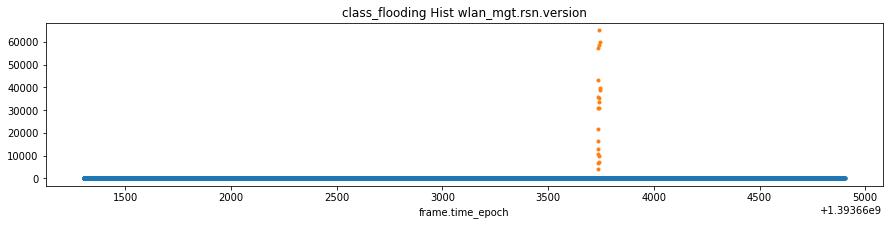

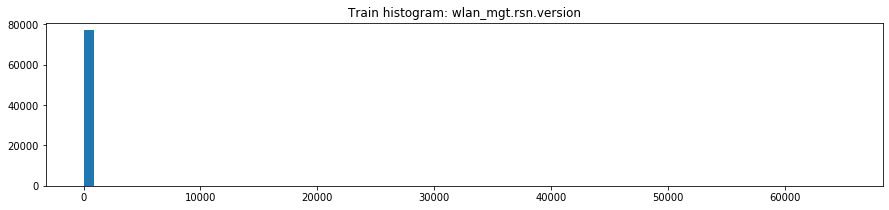

,wlan_mgt.rsn.version,Train,Train impersonation,Train not impersonation
0,count,7.694400e+04,20.000000,76924.000
1,mean,9.047788e+00,30962.450000,1.000
2,std,5.849112e+02,19407.779982,0.000
3,min,1.000000e+00,4123.000000,1.000
4,25%,1.000000e+00,12244.500000,1.000
5,50%,1.000000e+00,32349.000000,1.000
6,75%,1.000000e+00,40698.750000,1.000
7,max,6.513800e+04,65138.000000,1.000
8,unique values,2.200000e+01,21.000000,2.000
9,NaNs,1.718630e+06,48464.000000,1670166.000


,wlan_mgt.rsn.version,Count in train (desc),Mean target train,Sum target train
0,1.0,76924,0,0
1,33769.0,1,1,1
2,59917.0,1,1,1
3,58602.0,1,1,1
4,57385.0,1,1,1
5,43284.0,1,1,1
6,39837.0,1,1,1
7,38936.0,1,1,1
8,35713.0,1,1,1
9,35191.0,1,1,1


,wlan_mgt.rsn.version,Count in test (desc),Mean target test,Sum target test
0,1.0,33208,0,0


,Column,Correlation with wlan_mgt.rsn.version
0,wlan_mgt.rsn.version,1.000000
1,class_flooding,0.853307
2,wlan_mgt.rsn.akms.count,0.831186
3,wlan_mgt.rsn.pcs.count,0.830173
4,wlan_mgt.fixed.capabilities.pbcc,0.803228
5,wlan_mgt.fixed.capabilities.del_blk_ack,0.762985
35,wlan.fc.subtype,-0.043443
36,wlan_mgt.fixed.capabilities.privacy,-0.567678
37,wlan_mgt.fixed.capabilities.short_slot_time,-0.665522
38,wlan_mgt.fixed.capabilities.ess,-0.765080


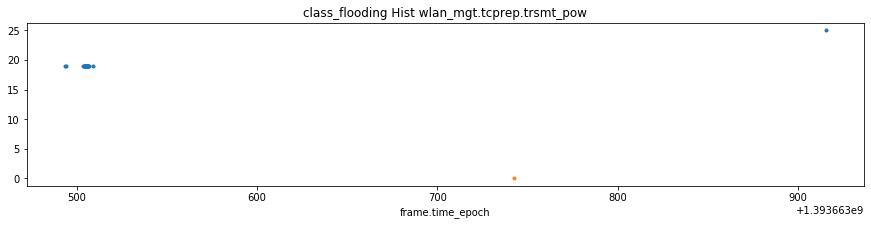

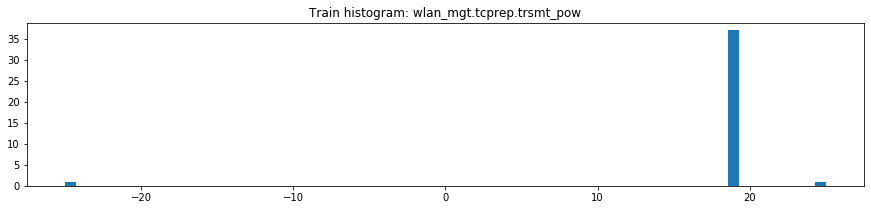

,wlan_mgt.tcprep.trsmt_pow,Train,Train impersonation,Train not impersonation
0,count,3.900000e+01,1.0,3.800000e+01
1,mean,1.802564e+01,-25.0,1.915789e+01
2,std,7.135852e+00,NaN,9.733285e-01
3,min,-2.500000e+01,-25.0,1.900000e+01
4,25%,1.900000e+01,-25.0,1.900000e+01
5,50%,1.900000e+01,-25.0,1.900000e+01
6,75%,1.900000e+01,-25.0,1.900000e+01
7,max,2.500000e+01,-25.0,2.500000e+01
8,unique values,4.000000e+00,2.0,3.000000e+00
9,NaNs,1.795535e+06,48483.0,1.747052e+06


,wlan_mgt.tcprep.trsmt_pow,Count in train (desc),Mean target train,Sum target train
0,19.0,37,0,0
1,-25.0,1,1,1
2,25.0,1,0,0


,wlan_mgt.tcprep.trsmt_pow,Count in test (desc),Mean target test,Sum target test


,Column,Correlation with wlan_mgt.tcprep.trsmt_pow
0,wlan_mgt.tcprep.trsmt_pow,1.000000
1,wlan_mgt.fixed.capabilities.ess,0.990901
2,class_normal,0.990901
3,wlan_mgt.fixed.capabilities.privacy,0.990901
4,wlan_mgt.tcprep.link_mrg,0.990901
5,wlan.seq,0.397393
20,wlan_mgt.fixed.capabilities.agility,-0.990901
21,wlan_mgt.fixed.capabilities.apsd,-0.990901
22,wlan_mgt.fixed.capabilities.del_blk_ack,-0.990901
23,class_flooding,-0.990901


,wlan.tkip.extiv,Train,Train impersonation,Train not impersonation
0,count,31920,0,31920
1,unique,31257,0,31257
2,top,0x0003AAA991D3,NaN,0x0003AAA991D3
3,freq,51,NaN,51
4,unique values,31258,1,31258
5,NaNs,1763654,48484,1715170
6,NaNs share,0.9822,1,0.9817


,wlan.tkip.extiv,Count in train (desc),Mean target train,Sum target train
0,0x0003AAA991D3,51,0,0
1,0x0003AAA99485,50,0,0
2,0x0003AAA991CF,50,0,0
3,0x0003AAA99489,48,0,0
4,0x0003AAA991E2,44,0,0
5,0x0003AAA991DA,44,0,0
6,0x0003AAA991DE,44,0,0
7,0x0003AAA991E9,41,0,0
8,0x000000000003,13,0,0
9,0x000000000001,12,0,0


,wlan.tkip.extiv,Count in test (desc),Mean target test,Sum target test
0,0x0003AAAA48BF,60,0,0
1,0x0003AAAA48AA,41,0,0
2,0x0000000048BF,8,0,0
3,0x0000000048AA,7,0,0
4,0x000000005500,4,0,0
5,0x000000008700,4,0,0
6,0x000000000011,4,0,0
7,0x000000003200,4,0,0
8,0x0000000080E5,3,0,0
9,0x0000000080F8,3,0,0


,wlan.ccmp.extiv,Train,Train impersonation,Train not impersonation
0,count,3069,0,3069
1,unique,967,0,967
2,top,0x000000000001,NaN,0x000000000001
3,freq,27,NaN,27
4,unique values,968,1,968
5,NaNs,1792505,48484,1744021
6,NaNs share,0.9983,1,0.9982


,wlan.ccmp.extiv,Count in train (desc),Mean target train,Sum target train
0,0x000000000001,27,0,0
1,0x000000000002,24,0,0
2,0x000000000005,21,0,0
3,0x000000000090,20,0,0
4,0x00000000007F,20,0,0
5,0x000000000067,18,0,0
6,0x000000000092,16,0,0
7,0x000000000003,16,0,0
8,0x000000000004,16,0,0
9,0x000000000039,15,0,0


,wlan.ccmp.extiv,Count in test (desc),Mean target test,Sum target test
0,0x00000000C8E1,13,0,0
1,0x0000000008C3,13,0,0
2,0x000000004029,9,0,0
3,0x000000008783,9,0,0
4,0x0000000000B7,9,0,0
5,0x00000000000E,9,0,0
6,0x00000000554C,8,0,0
7,0x0000000000B6,8,0,0
8,0x000000000284,8,0,0
9,0x000000000001,7,0,0


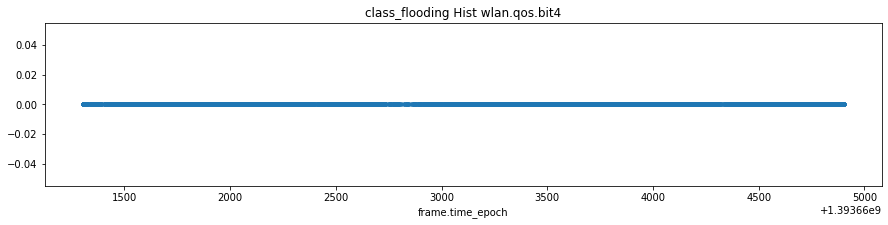

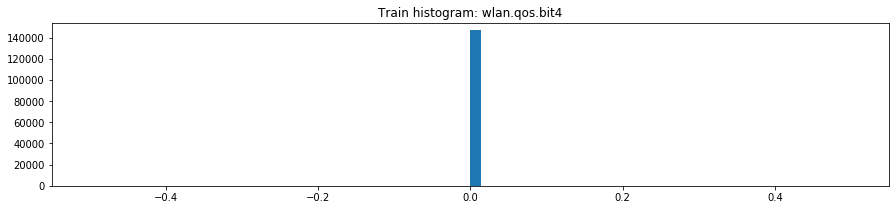

,wlan.qos.bit4,Train,Train impersonation,Train not impersonation
0,count,1.466400e+05,0.0,1.466400e+05
1,mean,0.000000e+00,NaN,0.000000e+00
2,std,0.000000e+00,NaN,0.000000e+00
3,min,0.000000e+00,NaN,0.000000e+00
4,25%,0.000000e+00,NaN,0.000000e+00
5,50%,0.000000e+00,NaN,0.000000e+00
6,75%,0.000000e+00,NaN,0.000000e+00
7,max,0.000000e+00,NaN,0.000000e+00
8,unique values,2.000000e+00,1.0,2.000000e+00
9,NaNs,1.648934e+06,48484.0,1.600450e+06


,wlan.qos.bit4,Count in train (desc),Mean target train,Sum target train
0,0.0,146640,0,0


,wlan.qos.bit4,Count in test (desc),Mean target test,Sum target test
0,0.0,40575,0,0


,Column,Correlation with wlan.qos.bit4
0,frame.interface_id,NaN
1,frame.dlt,NaN
2,frame.offset_shift,NaN
3,frame.time_epoch,NaN
4,frame.time_delta,NaN
5,frame.time_delta_displayed,NaN


In [20]:
for col in columns:
    proc(df=train_eda, tcol='frame.time_epoch', target='class_flooding', col=col, target_first=False, df_test=test_eda, include_test=False)